In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


import torchvision
import torchvision.models as models
from torch import optim
from torchvision.datasets import ImageFolder

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm
from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import random 
import numpy as np

def init_seeds(seed=0, cuda_deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Speed-reproducibility tradeoff https://pytorch.org/docs/stable/notes/randomness.html
    if cuda_deterministic:  # slower, more reproducible
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:  # faster, less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

# Set random seed for reproducibility
init_seeds(4673)

In [4]:
# Declare data augmentation transforms
def transform_data(mode):
    if mode=='train':
        img_transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.RandomHorizontalFlip(),
            T.RandomRotation(10),
            T.RandomGrayscale(),
            T.ToTensor(),
            T.Normalize([0.489, 0.456, 0.406], [0.229, 0.224, 0.225])
            
        ])
    elif mode=='val':
        img_transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize([0.489, 0.456, 0.406], [0.229, 0.224, 0.225])
            
        ])
    else:
        img_transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize([0.489, 0.456, 0.406], [0.229, 0.224, 0.225])
            
        ])
        
    return img_transforms

In [5]:
import os.path as osp



data_root_path = "/home/akash/spring23_coursework/cap5516/a1/chest_xray"
    
# Load datasets
train_dataset = ImageFolder(osp.join(data_root_path, 'train'), transform=transform_data(mode='train'))
val_dataset = ImageFolder(osp.join(data_root_path, 'val'), transform=transform_data(mode='val'))
test_dataset = ImageFolder(osp.join(data_root_path, 'test'), transform=transform_data(mode='test'))

print("number of images in Tran dataset:", len(train_dataset))
print("Number of images in val dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))

number of images in Tran dataset: 5216
Number of images in val dataset: 16
Number of images in test dataset: 624


In [6]:
print("Dataset classes:", train_dataset.classes)
print("Labels value:", train_dataset.class_to_idx)

Dataset classes: ['NORMAL', 'PNEUMONIA']
Labels value: {'NORMAL': 0, 'PNEUMONIA': 1}


In [7]:
# HYPERPARAMS
BATCH_SIZE = 48
LR = 0.001
N_EPOCHS = 20

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


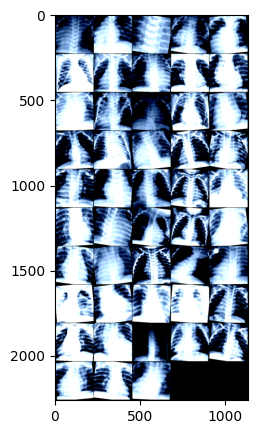

In [8]:
# Data visualization - Train
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for sample_imgs, sample_trgt in train_loader:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(make_grid(sample_imgs, nrow=5).permute(1, 2, 0))
    break

In [9]:
# scratch
# Define model
model = torchvision.models.resnet50(weights=None).to(device)
# # modify fc layer
model.fc = nn.Linear(2048, 2).to(device) # number of classes -2 

# define criterion
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0, eps=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-7, patience=5, factor=0.1,
                                                    verbose=True)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 45], gamma=0.1, verbose=True)


In [10]:
# savelogs
import os
import time

exp_id = 'scratch'
save_path = os.path.join('./train_log_wts', exp_id)
model_save_dir = os.path.join(save_path, time.strftime('%m-%d-%H-%M'))
writer = SummaryWriter(model_save_dir)
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [86]:
import sys

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def train(model, train_loader, criterion, optimizer, epoch, writer):
    model.train()
    steps = len(train_loader)
    train_loss = 0.0
    train_acc = 0.0
    
    for batch_id, (imgs, trgt) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        
        imgs = imgs.to(device)
        trgt = trgt.to(device)
        
        preds = model(imgs)
        loss = criterion(preds, trgt)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # _, outputs = torch.max(preds, dim=1)
        temp_acc, _ = accuracy(preds, trgt)
        train_acc+=temp_acc
        # print freq = 50
        # if (batch_id+1) %20==0:
        #     running_loss = train_loss / batch_id
        #     running_acc = train_acc / batch_id
        #     # print(f'[TRAIN] epoch-{epoch:0{len(str(epoch))}}/20,'
        #     #         f'batch-{batch_id + 1:0{len(str(steps))}}/{steps},'
        #     #         f'[LOSS]-{running_loss:.3f}, [ACC]-{running_acc:.3f}')
            
        # summary writing
        total_step = (epoch - 1) * len(train_loader) + batch_id + 1
        info = {
            'loss': train_loss/(batch_id+1),
            'acc': train_acc/(batch_id+1),
        }
        
        writer.add_scalars('train', info, total_step)
        sys.stdout.flush()
        
        
    return train_loss/len(train_loader), train_acc/len(train_loader)

def validate(model, val_loader, criterion, epoch, writer):
    model.eval()
    steps = len(val_loader)
    
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for batch_id, (imgs, trgt) in tqdm(enumerate(val_loader)):
            imgs = imgs.to(device)
            trgt = trgt.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, trgt)
            
            val_loss += loss.item()
            
            temp_acc, _ = accuracy(preds, trgt)
            val_acc += temp_acc
            # # print freq = 100
            # if (batch_id+1) %20==0:
            #     running_loss = val_loss / batch_id
            #     running_acc = val_acc / batch_id
            #     print(f'[VAL] epoch-{epoch:0{len(str(epoch))}}/50,'
            #             f'batch-{batch_id + 1:0{len(str(steps))}}/{steps},'
            #             f'[LOSS]-{running_loss:.3f}, [ACC]-{running_acc:.3f}')
                
            #     # summary writing
            total_step = (epoch - 1) * len(val_loader) + batch_id + 1
            info = {
                'loss': val_loss/(batch_id+1),
                'acc': val_acc/(batch_id+1),
            }
            
            writer.add_scalars('val', info, total_step)
            sys.stdout.flush()
            
        # print(f'[VAL]: Loss: {val_loss/len(val_loader)}, Acc: {val_acc/len(val_loader)}')
        return val_loss/len(val_loader), val_acc/len(val_loader)

In [13]:
# paths and loss values - Initialization
prev_best_val_loss = 10000
prev_best_train_loss = 10000
prev_best_val_loss_model_path = None
prev_best_train_loss_model_path = None
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for e in tqdm(range(1, N_EPOCHS + 1)):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, e, writer)
    val_loss, val_acc = validate(model, val_loader, criterion, e, writer)
    
    if val_loss < prev_best_val_loss:
        print("Yay!!! Got the val loss down...")
        val_model_path = os.path.join(model_save_dir, f'best_model_val_loss_{e}.pth')
        torch.save(model.state_dict(), val_model_path)
        prev_best_val_loss = val_loss
        if prev_best_val_loss_model_path and e < 25:
            os.remove(prev_best_val_loss_model_path)
        prev_best_val_loss_model_path = val_model_path

    if train_loss < prev_best_train_loss:
        print("Yay!!! Got the train loss down...")
        train_model_path = os.path.join(model_save_dir, f'best_model_train_loss_{e}.pth')
        torch.save(model.state_dict(), train_model_path)
        prev_best_train_loss = train_loss
        if prev_best_train_loss_model_path and e<25:
        # if prev_best_train_loss_model_path:
            os.remove(prev_best_train_loss_model_path)
        prev_best_train_loss_model_path = train_model_path
    scheduler.step(val_loss)
    print(f'[TRAIN] epoch-{e:0{len(str(e))}}/20,'
                f'[LOSS]-{train_loss:.3f}, [ACC]-{train_acc:.3f}')
    
    print(f'[VAL] epoch-{e:0{len(str(e))}}/20,'
                f'[LOSS]-{val_loss:.3f}, [ACC]-{val_acc:.3f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)


109it [00:16,  6.59it/s]0:00<?, ?it/s]
1it [00:00,  3.26it/s]


[VAL]: Loss: 1.4266040325164795, Acc: 0.5625
Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


  5%|▌         | 1/20 [00:17<05:38, 17.80s/it]

[TRAIN] epoch-1/20,[LOSS]-0.237, [ACC]-0.907
[VAL] epoch-1/20,[LOSS]-1.427, [ACC]-0.562


109it [00:13,  7.81it/s]
1it [00:00,  3.20it/s]


[VAL]: Loss: 0.566339373588562, Acc: 0.625
Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


 10%|█         | 2/20 [00:33<04:55, 16.42s/it]

[TRAIN] epoch-2/20,[LOSS]-0.177, [ACC]-0.930
[VAL] epoch-2/20,[LOSS]-0.566, [ACC]-0.625


109it [00:13,  7.79it/s]
1it [00:00,  3.12it/s]
 15%|█▌        | 3/20 [00:48<04:30, 15.94s/it]

[VAL]: Loss: 0.7855786681175232, Acc: 0.5625
Yay!!! Got the train loss down...
[TRAIN] epoch-3/20,[LOSS]-0.150, [ACC]-0.946
[VAL] epoch-3/20,[LOSS]-0.786, [ACC]-0.562


109it [00:14,  7.68it/s]
1it [00:00,  3.28it/s]


[VAL]: Loss: 0.5204240083694458, Acc: 0.6875
Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


 20%|██        | 4/20 [01:04<04:13, 15.84s/it]

[TRAIN] epoch-4/20,[LOSS]-0.133, [ACC]-0.949
[VAL] epoch-4/20,[LOSS]-0.520, [ACC]-0.688


109it [00:14,  7.74it/s]
1it [00:00,  3.22it/s]
 25%|██▌       | 5/20 [01:19<03:55, 15.71s/it]

[VAL]: Loss: 1.4977141618728638, Acc: 0.5625
Yay!!! Got the train loss down...
[TRAIN] epoch-5/20,[LOSS]-0.113, [ACC]-0.959
[VAL] epoch-5/20,[LOSS]-1.498, [ACC]-0.562


109it [00:14,  7.64it/s]
1it [00:00,  3.19it/s]
 30%|███       | 6/20 [01:35<03:39, 15.71s/it]

[VAL]: Loss: 1.5198527574539185, Acc: 0.625
Yay!!! Got the train loss down...
[TRAIN] epoch-6/20,[LOSS]-0.110, [ACC]-0.959
[VAL] epoch-6/20,[LOSS]-1.520, [ACC]-0.625


109it [00:14,  7.73it/s]
1it [00:00,  3.13it/s]
 35%|███▌      | 7/20 [01:51<03:23, 15.65s/it]

[VAL]: Loss: 0.3625636696815491, Acc: 0.8125
Yay!!! Got the val loss down...
[TRAIN] epoch-7/20,[LOSS]-0.111, [ACC]-0.957
[VAL] epoch-7/20,[LOSS]-0.363, [ACC]-0.812


109it [00:14,  7.66it/s]
1it [00:00,  3.16it/s]


[VAL]: Loss: 0.18903575837612152, Acc: 1.0
Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


 40%|████      | 8/20 [02:06<03:08, 15.68s/it]

[TRAIN] epoch-8/20,[LOSS]-0.095, [ACC]-0.964
[VAL] epoch-8/20,[LOSS]-0.189, [ACC]-1.000


109it [00:14,  7.73it/s]
1it [00:00,  2.91it/s]
 45%|████▌     | 9/20 [02:22<02:51, 15.59s/it]

[VAL]: Loss: 0.5774036645889282, Acc: 0.6875
[TRAIN] epoch-9/20,[LOSS]-0.114, [ACC]-0.956
[VAL] epoch-9/20,[LOSS]-0.577, [ACC]-0.688


109it [00:14,  7.66it/s]
1it [00:00,  3.18it/s]
 50%|█████     | 10/20 [02:37<02:35, 15.56s/it]

[VAL]: Loss: 0.9471350312232971, Acc: 0.6875
[TRAIN] epoch-10/20,[LOSS]-0.102, [ACC]-0.963
[VAL] epoch-10/20,[LOSS]-0.947, [ACC]-0.688


109it [00:14,  7.69it/s]
1it [00:00,  3.15it/s]
 55%|█████▌    | 11/20 [02:53<02:20, 15.57s/it]

[VAL]: Loss: 1.1752700805664062, Acc: 0.6875
Yay!!! Got the train loss down...
[TRAIN] epoch-11/20,[LOSS]-0.094, [ACC]-0.965
[VAL] epoch-11/20,[LOSS]-1.175, [ACC]-0.688


109it [00:14,  7.72it/s]
1it [00:00,  3.16it/s]
 60%|██████    | 12/20 [03:08<02:04, 15.55s/it]

[VAL]: Loss: 1.4143060445785522, Acc: 0.625
Yay!!! Got the train loss down...
[TRAIN] epoch-12/20,[LOSS]-0.086, [ACC]-0.967
[VAL] epoch-12/20,[LOSS]-1.414, [ACC]-0.625


109it [00:14,  7.69it/s]
1it [00:00,  3.19it/s]
 65%|██████▌   | 13/20 [03:24<01:48, 15.50s/it]

[VAL]: Loss: 1.4692453145980835, Acc: 0.5625
[TRAIN] epoch-13/20,[LOSS]-0.090, [ACC]-0.967
[VAL] epoch-13/20,[LOSS]-1.469, [ACC]-0.562


109it [00:14,  7.69it/s]
1it [00:00,  3.16it/s]
 70%|███████   | 14/20 [03:39<01:32, 15.48s/it]

[VAL]: Loss: 1.0803992748260498, Acc: 0.625
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
[TRAIN] epoch-14/20,[LOSS]-0.091, [ACC]-0.966
[VAL] epoch-14/20,[LOSS]-1.080, [ACC]-0.625


109it [00:14,  7.64it/s]
1it [00:00,  3.14it/s]
 75%|███████▌  | 15/20 [03:55<01:17, 15.53s/it]

[VAL]: Loss: 0.7649213671684265, Acc: 0.6875
Yay!!! Got the train loss down...
[TRAIN] epoch-15/20,[LOSS]-0.062, [ACC]-0.978
[VAL] epoch-15/20,[LOSS]-0.765, [ACC]-0.688


109it [00:14,  7.72it/s]
1it [00:00,  3.20it/s]
 80%|████████  | 16/20 [04:10<01:02, 15.53s/it]

[VAL]: Loss: 0.5831366181373596, Acc: 0.6875
Yay!!! Got the train loss down...
[TRAIN] epoch-16/20,[LOSS]-0.057, [ACC]-0.978
[VAL] epoch-16/20,[LOSS]-0.583, [ACC]-0.688


109it [00:14,  7.66it/s]
1it [00:00,  3.22it/s]
 85%|████████▌ | 17/20 [04:26<00:46, 15.56s/it]

[VAL]: Loss: 0.4909984767436981, Acc: 0.75
Yay!!! Got the train loss down...
[TRAIN] epoch-17/20,[LOSS]-0.052, [ACC]-0.981
[VAL] epoch-17/20,[LOSS]-0.491, [ACC]-0.750


109it [00:14,  7.71it/s]
1it [00:00,  3.05it/s]
 90%|█████████ | 18/20 [04:41<00:31, 15.51s/it]

[VAL]: Loss: 0.45211145281791687, Acc: 0.8125
[TRAIN] epoch-18/20,[LOSS]-0.054, [ACC]-0.980
[VAL] epoch-18/20,[LOSS]-0.452, [ACC]-0.812


109it [00:14,  7.68it/s]
1it [00:00,  3.20it/s]
 95%|█████████▌| 19/20 [04:57<00:15, 15.53s/it]

[VAL]: Loss: 0.7362172603607178, Acc: 0.75
Yay!!! Got the train loss down...
[TRAIN] epoch-19/20,[LOSS]-0.049, [ACC]-0.980
[VAL] epoch-19/20,[LOSS]-0.736, [ACC]-0.750


109it [00:14,  7.72it/s]
1it [00:00,  3.21it/s]
100%|██████████| 20/20 [05:12<00:00, 15.63s/it]

[VAL]: Loss: 0.3387173116207123, Acc: 0.8125
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
[TRAIN] epoch-20/20,[LOSS]-0.049, [ACC]-0.981
[VAL] epoch-20/20,[LOSS]-0.339, [ACC]-0.812


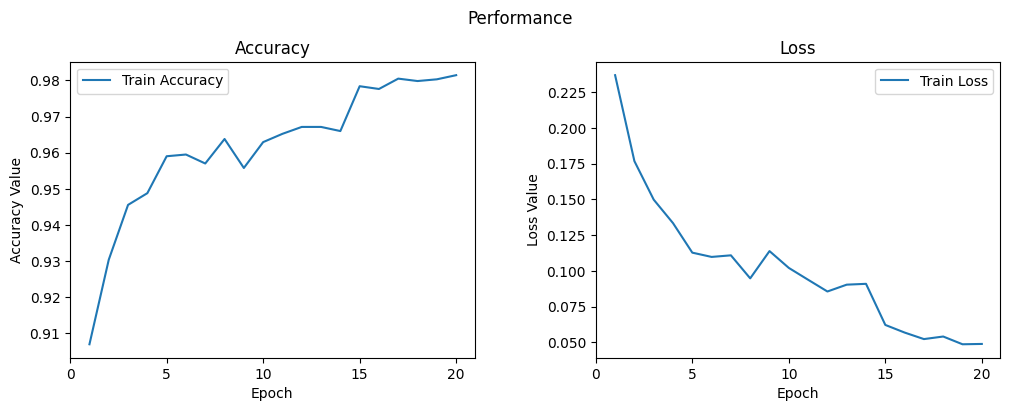

In [16]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,N_EPOCHS+1))
ax1.plot(epoch_list, train_accs, label='Train Accuracy')
ax1.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_losses, label='Train Loss')
ax2.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

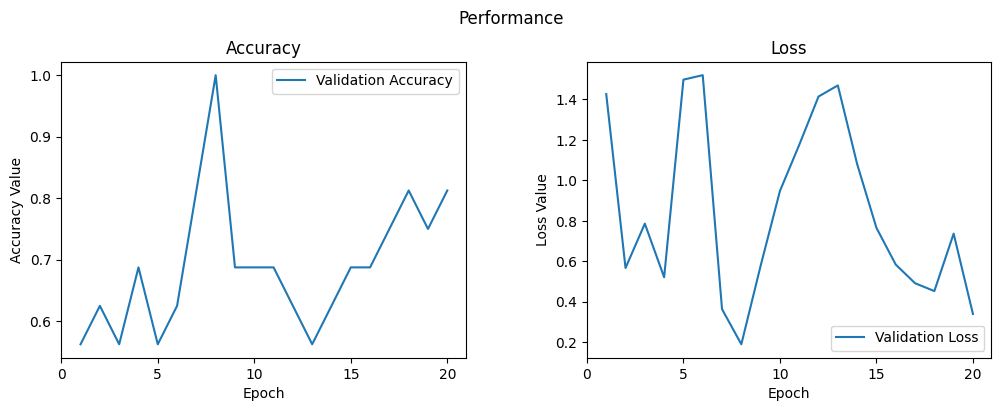

In [18]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,N_EPOCHS+1))
ax1.plot(epoch_list, val_accs, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, val_losses, label='Validation Loss')
ax2.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [92]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    acc_list = []
    pred_list = []
    
    with torch.no_grad():
        for batch_id, (imgs, trgt) in tqdm(enumerate(test_loader)):
            imgs = imgs.to(device)
            trgt = trgt.to(device)
            preds = model(imgs)
            loss = criterion(preds, trgt)
            
            test_loss += loss.item()
            
            temp_acc, temp_preds= accuracy(preds, trgt)
            acc_list.append(trgt)
            pred_list.append(temp_preds)
            test_acc += temp_acc
            
        print(f'[TEST]: Loss: {test_loss/len(test_loader)}, Acc: {test_acc/len(test_loader)}')
        return acc_list, pred_list 

model.load_state_dict(torch.load('train_log_wts/scratch/03-21-03-30/best_model_val_loss_5.pth'), strict=True)

# define criterion
criterion = nn.CrossEntropyLoss()

acc, pred = test(model, test_loader, criterion)


13it [00:01,  7.13it/s]

[TEST]: Loss: 0.6130139736028818, Acc: 0.8413461446762085


In [93]:
samples_names =[]
for i in test_loader.dataset.samples:
    samples_names.append(i[0])

accs = []
predss = []
for i in range(len(acc)):
    accs+= acc[i]
for i in range(len(pred)):
    predss+=pred[i]

accs = [i.item() for i in accs]
predss = [i.item() for i in predss] 


<Figure size 640x480 with 0 Axes>

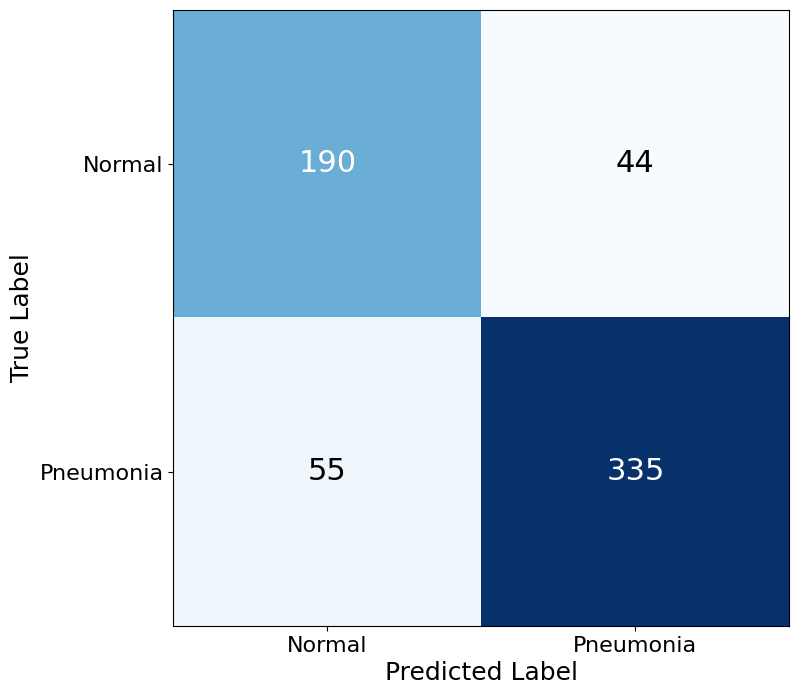

In [98]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib
# Plot confusion matrix
cm  = confusion_matrix(accs, predss)
matplotlib.rcParams.update({'font.size': 22})
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [63]:
# Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([0.81196581, 0.85897436])

Normal - acc - 81.2, Pneumonia - acc - 85.9

In [65]:
mismatch_indexes = []
gt_mismatched = []
pred_mismatched = []

counter = 0
for i, (j, k) in enumerate(zip(accs, predss)):
    if j!=k:
        mismatch_indexes.append(i)
        gt_mismatched.append(j)
        pred_mismatched.append(k)
        counter +=1
        # if counter==10: break
print(counter)
print(mismatch_indexes, gt_mismatched, pred_mismatched)        
# for sample_imgs, sample_trgt in train_loader:
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.imshow(make_grid(sample_imgs, nrow=5).permute(1, 2, 0))
#     break

99
[15, 16, 17, 61, 62, 77, 89, 116, 117, 118, 119, 124, 126, 129, 130, 133, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 159, 167, 171, 172, 181, 182, 195, 198, 200, 204, 209, 216, 218, 219, 226, 228, 231, 234, 254, 255, 276, 282, 287, 293, 299, 317, 322, 335, 355, 368, 371, 377, 388, 391, 401, 404, 405, 406, 410, 411, 412, 414, 418, 420, 446, 465, 472, 473, 494, 496, 501, 504, 508, 510, 511, 512, 514, 519, 520, 524, 525, 526, 530, 541, 552, 565, 581, 586, 599, 608, 609, 623] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

44


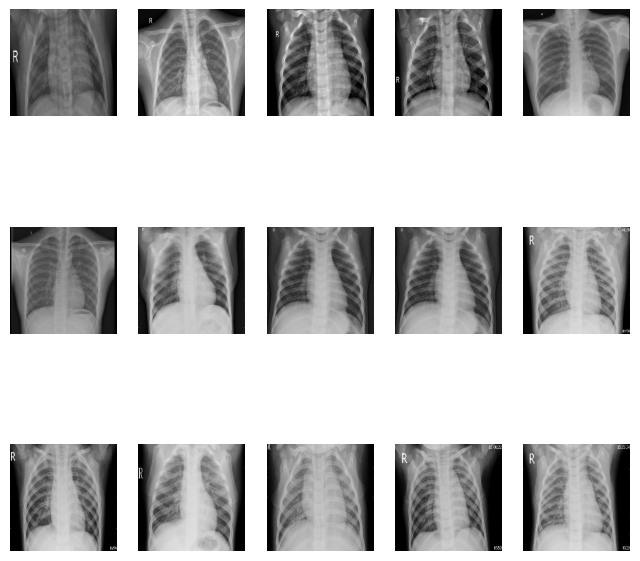

In [79]:
sample_failure_normal_imgs = [samples_names[i] for i,j in zip(mismatch_indexes, gt_mismatched) if j==0]
print(len(sample_failure_normal_imgs))
import cv2
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    # img = np.random.randint(10, size=(h,w))
    img = cv2.resize(cv2.imread(sample_failure_normal_imgs[i]), (224, 224))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Failure cases of NORMAL

55


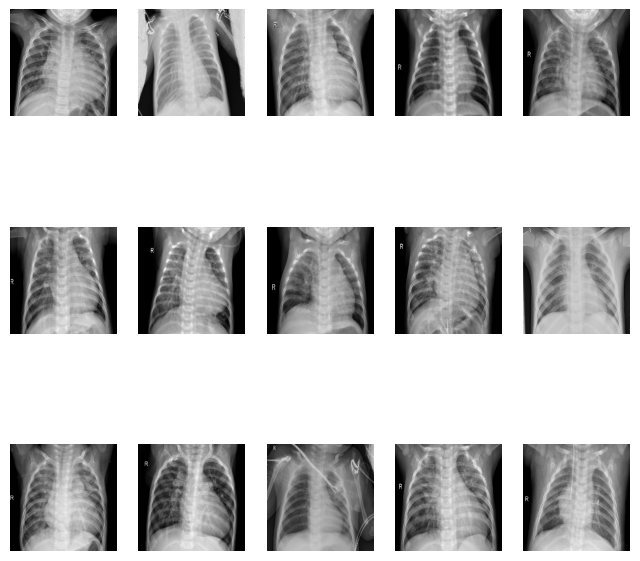

In [80]:
sample_failure_pneu_imgs = [samples_names[i] for i,j in zip(mismatch_indexes, gt_mismatched) if j==1]
print(len(sample_failure_pneu_imgs))
import cv2
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    # img = np.random.randint(10, size=(h,w))
    img = cv2.resize(cv2.imread(sample_failure_pneu_imgs[i]), (224, 224))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Failure cases of Pneumonia 

In [84]:
# FT all
# Define model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)
# # modify fc layer
model.fc = nn.Linear(2048, 2).to(device) # number of classes -2 

print("trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
# define criterion
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0, eps=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-7, patience=5, factor=0.1,
                                                    verbose=True)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 45], gamma=0.1, verbose=True)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/akash/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

trainable params: 23512130


In [85]:
# savelogs
import os
import time

exp_id = 'ft_all'
save_path = os.path.join('./train_log_wts', exp_id)
model_save_dir = os.path.join(save_path, time.strftime('%m-%d-%H-%M'))
writer = SummaryWriter(model_save_dir)
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [87]:
# paths and loss values - Initialization
prev_best_val_loss = 10000
prev_best_train_loss = 10000
prev_best_val_loss_model_path = None
prev_best_train_loss_model_path = None
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for e in tqdm(range(1, N_EPOCHS + 1)):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, e, writer)
    val_loss, val_acc = validate(model, val_loader, criterion, e, writer)
    
    if val_loss < prev_best_val_loss:
        print("Yay!!! Got the val loss down...")
        val_model_path = os.path.join(model_save_dir, f'best_model_val_loss_{e}.pth')
        torch.save(model.state_dict(), val_model_path)
        prev_best_val_loss = val_loss
        if prev_best_val_loss_model_path and e < 25:
            os.remove(prev_best_val_loss_model_path)
        prev_best_val_loss_model_path = val_model_path

    if train_loss < prev_best_train_loss:
        print("Yay!!! Got the train loss down...")
        train_model_path = os.path.join(model_save_dir, f'best_model_train_loss_{e}.pth')
        torch.save(model.state_dict(), train_model_path)
        prev_best_train_loss = train_loss
        if prev_best_train_loss_model_path and e<25:
        # if prev_best_train_loss_model_path:
            os.remove(prev_best_train_loss_model_path)
        prev_best_train_loss_model_path = train_model_path
    scheduler.step(val_loss)
    print(f'[TRAIN] epoch-{e:0{len(str(e))}}/20,'
                f'[LOSS]-{train_loss:.3f}, [ACC]-{train_acc:.3f}')
    
    print(f'[VAL] epoch-{e:0{len(str(e))}}/20,'
                f'[LOSS]-{val_loss:.3f}, [ACC]-{val_acc:.3f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)

109it [00:14,  7.50it/s]0:00<?, ?it/s]
1it [00:00,  2.89it/s]


Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


  5%|▌         | 1/20 [00:16<05:05, 16.08s/it]

[TRAIN] epoch-1/20,[LOSS]-0.135, [ACC]-0.947
[VAL] epoch-1/20,[LOSS]-0.490, [ACC]-0.875


109it [00:13,  7.79it/s]
1it [00:00,  3.13it/s]


Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


 10%|█         | 2/20 [00:31<04:43, 15.74s/it]

[TRAIN] epoch-2/20,[LOSS]-0.101, [ACC]-0.961
[VAL] epoch-2/20,[LOSS]-0.463, [ACC]-0.750


109it [00:13,  7.82it/s]
1it [00:00,  3.14it/s]
 15%|█▌        | 3/20 [00:46<04:24, 15.57s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-3/20,[LOSS]-0.082, [ACC]-0.965
[VAL] epoch-3/20,[LOSS]-1.057, [ACC]-0.688


109it [00:14,  7.77it/s]
1it [00:00,  3.13it/s]
 20%|██        | 4/20 [01:02<04:08, 15.53s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-4/20,[LOSS]-0.066, [ACC]-0.975
[VAL] epoch-4/20,[LOSS]-1.353, [ACC]-0.500


109it [00:14,  7.74it/s]
1it [00:00,  3.05it/s]
 25%|██▌       | 5/20 [01:17<03:53, 15.54s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-5/20,[LOSS]-0.065, [ACC]-0.974
[VAL] epoch-5/20,[LOSS]-0.507, [ACC]-0.625


109it [00:14,  7.75it/s]
1it [00:00,  3.06it/s]


Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


 30%|███       | 6/20 [01:33<03:38, 15.58s/it]

[TRAIN] epoch-6/20,[LOSS]-0.060, [ACC]-0.977
[VAL] epoch-6/20,[LOSS]-0.089, [ACC]-1.000


109it [00:14,  7.71it/s]
1it [00:00,  3.02it/s]
 35%|███▌      | 7/20 [01:49<03:22, 15.58s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-7/20,[LOSS]-0.056, [ACC]-0.981
[VAL] epoch-7/20,[LOSS]-0.274, [ACC]-0.812


109it [00:14,  7.67it/s]
1it [00:00,  3.12it/s]
 40%|████      | 8/20 [02:04<03:06, 15.57s/it]

[TRAIN] epoch-8/20,[LOSS]-0.062, [ACC]-0.977
[VAL] epoch-8/20,[LOSS]-0.406, [ACC]-0.812


109it [00:14,  7.65it/s]
1it [00:00,  3.03it/s]
 45%|████▌     | 9/20 [02:20<02:51, 15.61s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-9/20,[LOSS]-0.050, [ACC]-0.979
[VAL] epoch-9/20,[LOSS]-0.160, [ACC]-1.000


109it [00:14,  7.68it/s]
1it [00:00,  3.08it/s]
 50%|█████     | 10/20 [02:35<02:35, 15.58s/it]

[TRAIN] epoch-10/20,[LOSS]-0.055, [ACC]-0.978
[VAL] epoch-10/20,[LOSS]-0.332, [ACC]-0.812


109it [00:14,  7.66it/s]
1it [00:00,  3.16it/s]
 55%|█████▌    | 11/20 [02:51<02:20, 15.60s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-11/20,[LOSS]-0.049, [ACC]-0.979
[VAL] epoch-11/20,[LOSS]-0.559, [ACC]-0.750


109it [00:14,  7.66it/s]
1it [00:00,  3.08it/s]
 60%|██████    | 12/20 [03:07<02:04, 15.62s/it]

Yay!!! Got the train loss down...
Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
[TRAIN] epoch-12/20,[LOSS]-0.039, [ACC]-0.986
[VAL] epoch-12/20,[LOSS]-0.095, [ACC]-1.000


109it [00:14,  7.69it/s]
1it [00:00,  3.07it/s]
 65%|██████▌   | 13/20 [03:22<01:49, 15.63s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-13/20,[LOSS]-0.022, [ACC]-0.994
[VAL] epoch-13/20,[LOSS]-0.213, [ACC]-0.875


109it [00:14,  7.74it/s]
1it [00:00,  3.10it/s]
 70%|███████   | 14/20 [03:38<01:33, 15.60s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-14/20,[LOSS]-0.021, [ACC]-0.992
[VAL] epoch-14/20,[LOSS]-0.276, [ACC]-0.812


109it [00:14,  7.63it/s]
1it [00:00,  3.13it/s]
 75%|███████▌  | 15/20 [03:54<01:18, 15.64s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-15/20,[LOSS]-0.018, [ACC]-0.994
[VAL] epoch-15/20,[LOSS]-0.269, [ACC]-0.875


109it [00:14,  7.69it/s]
1it [00:00,  3.08it/s]
 80%|████████  | 16/20 [04:09<01:02, 15.63s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-16/20,[LOSS]-0.015, [ACC]-0.996
[VAL] epoch-16/20,[LOSS]-0.110, [ACC]-1.000


109it [00:14,  7.67it/s]
1it [00:00,  3.03it/s]
 85%|████████▌ | 17/20 [04:25<00:46, 15.64s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-17/20,[LOSS]-0.013, [ACC]-0.996
[VAL] epoch-17/20,[LOSS]-0.348, [ACC]-0.875


109it [00:14,  7.69it/s]
1it [00:00,  2.97it/s]
 90%|█████████ | 18/20 [04:41<00:31, 15.64s/it]

Yay!!! Got the train loss down...
Epoch 00018: reducing learning rate of group 0 to 1.0000e-05.
[TRAIN] epoch-18/20,[LOSS]-0.011, [ACC]-0.997
[VAL] epoch-18/20,[LOSS]-0.276, [ACC]-0.875


109it [00:14,  7.65it/s]
1it [00:00,  3.03it/s]
 95%|█████████▌| 19/20 [04:56<00:15, 15.65s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-19/20,[LOSS]-0.008, [ACC]-0.997
[VAL] epoch-19/20,[LOSS]-0.248, [ACC]-0.875


109it [00:14,  7.63it/s]
1it [00:00,  3.05it/s]
100%|██████████| 20/20 [05:12<00:00, 15.62s/it]

[TRAIN] epoch-20/20,[LOSS]-0.010, [ACC]-0.996
[VAL] epoch-20/20,[LOSS]-0.219, [ACC]-0.875


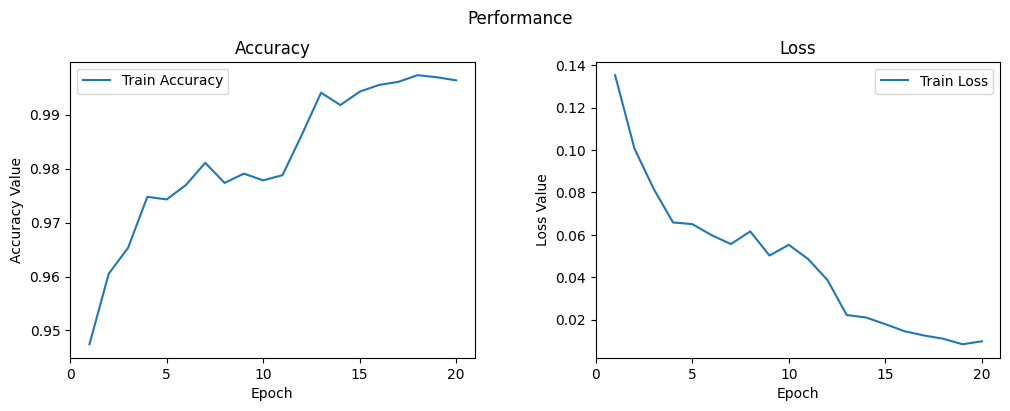

In [88]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,N_EPOCHS+1))
ax1.plot(epoch_list, train_accs, label='Train Accuracy')
ax1.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_losses, label='Train Loss')
ax2.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

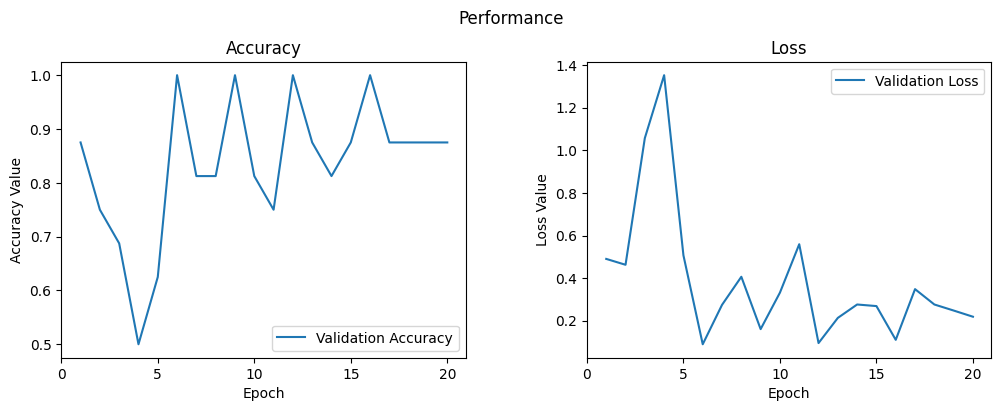

In [89]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,N_EPOCHS+1))
ax1.plot(epoch_list, val_accs, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, val_losses, label='Validation Loss')
ax2.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Best train wts acc

In [100]:
model.load_state_dict(torch.load('train_log_wts/ft_all/03-21-22-37/best_model_train_loss_19.pth'), strict=True)

# define criterion
criterion = nn.CrossEntropyLoss()

acc, pred = test(model, test_loader, criterion)

13it [00:01,  7.06it/s]

[TEST]: Loss: 0.9593473565356152, Acc: 0.8461538553237915


## Best val wts acc

##

In [101]:
model.load_state_dict(torch.load('train_log_wts/ft_all/03-21-22-37/best_model_val_loss_6.pth'), strict=True)

# define criterion
criterion = nn.CrossEntropyLoss()

acc, pred = test(model, test_loader, criterion)

13it [00:01,  7.05it/s]

[TEST]: Loss: 0.30264795743502104, Acc: 0.8926281332969666


In [102]:
samples_names =[]
for i in test_loader.dataset.samples:
    samples_names.append(i[0])

accs = []
predss = []
for i in range(len(acc)):
    accs+= acc[i]
for i in range(len(pred)):
    predss+=pred[i]

accs = [i.item() for i in accs]
predss = [i.item() for i in predss] 

<Figure size 640x480 with 0 Axes>

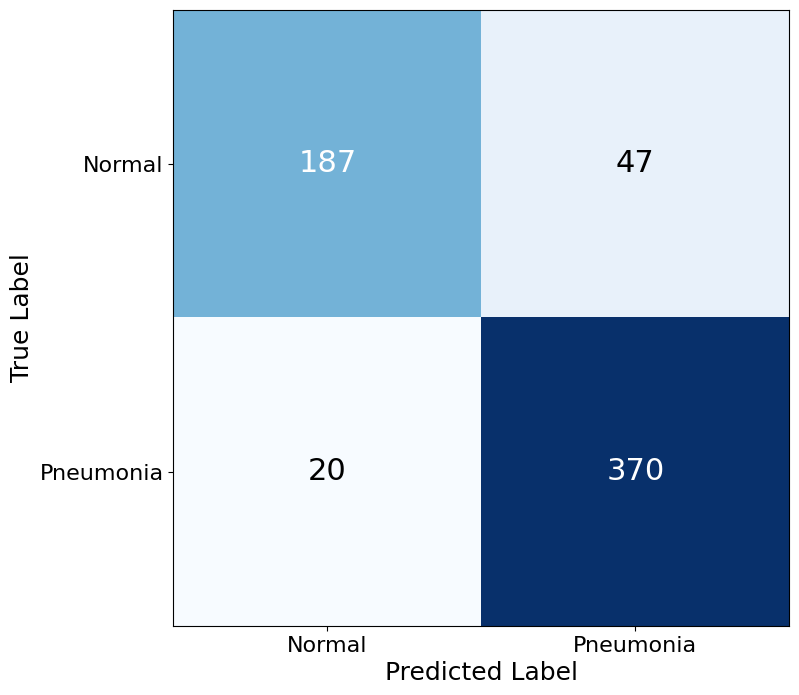

In [103]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib
# Plot confusion matrix
cm  = confusion_matrix(accs, predss)
matplotlib.rcParams.update({'font.size': 22})
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [104]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([0.7991453 , 0.94871795])

## Normal acc - 79.9, Pneumonia Acc - 94.8

In [105]:
mismatch_indexes = []
gt_mismatched = []
pred_mismatched = []

counter = 0
for i, (j, k) in enumerate(zip(accs, predss)):
    if j!=k:
        mismatch_indexes.append(i)
        gt_mismatched.append(j)
        pred_mismatched.append(k)
        counter +=1
        # if counter==10: break
print(counter)
print(mismatch_indexes, gt_mismatched, pred_mismatched)  

67
[3, 11, 16, 45, 52, 56, 61, 98, 116, 119, 120, 121, 122, 123, 124, 126, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 153, 160, 173, 181, 186, 193, 197, 200, 209, 217, 219, 226, 228, 248, 282, 287, 288, 317, 348, 371, 382, 388, 390, 391, 406, 437, 496, 519, 527, 529, 567, 599, 601] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


47


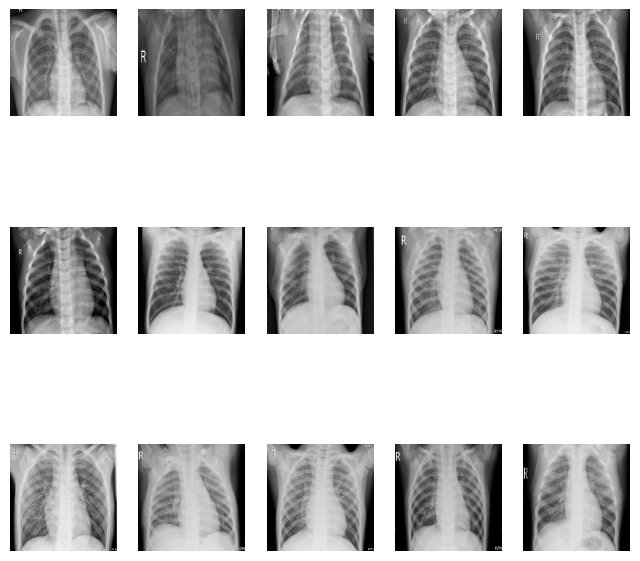

In [106]:
sample_failure_normal_imgs = [samples_names[i] for i,j in zip(mismatch_indexes, gt_mismatched) if j==0]
print(len(sample_failure_normal_imgs))
import cv2
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    # img = np.random.randint(10, size=(h,w))
    img = cv2.resize(cv2.imread(sample_failure_normal_imgs[i]), (224, 224))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Failure cases of Normal

20


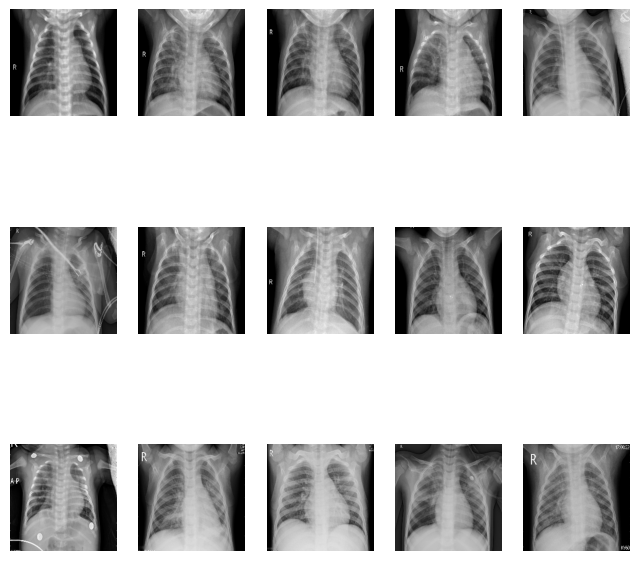

In [107]:
sample_failure_pneu_imgs = [samples_names[i] for i,j in zip(mismatch_indexes, gt_mismatched) if j==1]
print(len(sample_failure_pneu_imgs))
import cv2
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    # img = np.random.randint(10, size=(h,w))
    img = cv2.resize(cv2.imread(sample_failure_pneu_imgs[i]), (224, 224))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Failure cases of Pneumonia

In [110]:
# FT only FC layers
# Define model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)
# # modify fc layer
model.fc = nn.Linear(2048, 2).to(device) # number of classes -2 

print("trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

for name, params in model.named_parameters():
    if not name.startswith('fc'):
        params.requires_grad = False
print("trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# define criterion
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0, eps=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-7, patience=5, factor=0.1,
                                                    verbose=True)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 45], gamma=0.1, verbose=True)

trainable params: 23512130
trainable params: 4098


In [111]:
# savelogs
import os
import time

exp_id = 'ft_all'
save_path = os.path.join('./train_log_wts', exp_id)
model_save_dir = os.path.join(save_path, time.strftime('%m-%d-%H-%M'))
writer = SummaryWriter(model_save_dir)
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# paths and loss values - Initialization
prev_best_val_loss = 10000
prev_best_train_loss = 10000
prev_best_val_loss_model_path = None
prev_best_train_loss_model_path = None
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for e in tqdm(range(1, N_EPOCHS + 1)):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, e, writer)
    val_loss, val_acc = validate(model, val_loader, criterion, e, writer)
    
    if val_loss < prev_best_val_loss:
        print("Yay!!! Got the val loss down...")
        val_model_path = os.path.join(model_save_dir, f'best_model_val_loss_{e}.pth')
        torch.save(model.state_dict(), val_model_path)
        prev_best_val_loss = val_loss
        if prev_best_val_loss_model_path and e < 25:
            os.remove(prev_best_val_loss_model_path)
        prev_best_val_loss_model_path = val_model_path

    if train_loss < prev_best_train_loss:
        print("Yay!!! Got the train loss down...")
        train_model_path = os.path.join(model_save_dir, f'best_model_train_loss_{e}.pth')
        torch.save(model.state_dict(), train_model_path)
        prev_best_train_loss = train_loss
        if prev_best_train_loss_model_path and e<25:
        # if prev_best_train_loss_model_path:
            os.remove(prev_best_train_loss_model_path)
        prev_best_train_loss_model_path = train_model_path
    scheduler.step(val_loss)
    print(f'[TRAIN] epoch-{e:0{len(str(e))}}/20,'
                f'[LOSS]-{train_loss:.3f}, [ACC]-{train_acc:.3f}')
    
    print(f'[VAL] epoch-{e:0{len(str(e))}}/20,'
                f'[LOSS]-{val_loss:.3f}, [ACC]-{val_acc:.3f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)

109it [00:08, 12.21it/s]0:00<?, ?it/s]
1it [00:00,  3.06it/s]


Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


  5%|▌         | 1/20 [00:10<03:19, 10.47s/it]

[TRAIN] epoch-1/20,[LOSS]-0.284, [ACC]-0.879
[VAL] epoch-1/20,[LOSS]-0.848, [ACC]-0.625


109it [00:08, 12.19it/s]
1it [00:00,  2.91it/s]
 10%|█         | 2/20 [00:20<03:07, 10.44s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-2/20,[LOSS]-0.178, [ACC]-0.937
[VAL] epoch-2/20,[LOSS]-0.895, [ACC]-0.625


109it [00:08, 12.11it/s]
1it [00:00,  2.92it/s]


Yay!!! Got the val loss down...
Yay!!! Got the train loss down...


 15%|█▌        | 3/20 [00:31<02:58, 10.51s/it]

[TRAIN] epoch-3/20,[LOSS]-0.158, [ACC]-0.940
[VAL] epoch-3/20,[LOSS]-0.790, [ACC]-0.688


109it [00:08, 12.33it/s]
1it [00:00,  2.90it/s]
 20%|██        | 4/20 [00:41<02:46, 10.43s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-4/20,[LOSS]-0.147, [ACC]-0.944
[VAL] epoch-4/20,[LOSS]-1.034, [ACC]-0.625


109it [00:09, 11.96it/s]
1it [00:00,  3.03it/s]
 25%|██▌       | 5/20 [00:52<02:37, 10.49s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-5/20,[LOSS]-0.142, [ACC]-0.944
[VAL] epoch-5/20,[LOSS]-0.838, [ACC]-0.625


109it [00:08, 12.45it/s]
1it [00:00,  2.86it/s]
 30%|███       | 6/20 [01:02<02:25, 10.40s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-6/20,[LOSS]-0.134, [ACC]-0.951
[VAL] epoch-6/20,[LOSS]-0.869, [ACC]-0.625


109it [00:09, 11.92it/s]
1it [00:00,  3.05it/s]
 35%|███▌      | 7/20 [01:13<02:16, 10.46s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-7/20,[LOSS]-0.123, [ACC]-0.956
[VAL] epoch-7/20,[LOSS]-0.790, [ACC]-0.750


109it [00:08, 12.31it/s]
1it [00:00,  2.89it/s]
 40%|████      | 8/20 [01:23<02:04, 10.39s/it]

[TRAIN] epoch-8/20,[LOSS]-0.125, [ACC]-0.957
[VAL] epoch-8/20,[LOSS]-1.081, [ACC]-0.625


109it [00:08, 12.16it/s]
1it [00:00,  2.92it/s]
 45%|████▌     | 9/20 [01:33<01:54, 10.41s/it]

Yay!!! Got the train loss down...
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
[TRAIN] epoch-9/20,[LOSS]-0.120, [ACC]-0.954
[VAL] epoch-9/20,[LOSS]-0.927, [ACC]-0.688


109it [00:09, 12.03it/s]
1it [00:00,  2.93it/s]
 50%|█████     | 10/20 [01:44<01:44, 10.44s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-10/20,[LOSS]-0.111, [ACC]-0.960
[VAL] epoch-10/20,[LOSS]-0.892, [ACC]-0.688


109it [00:08, 12.41it/s]
1it [00:00,  3.01it/s]
 55%|█████▌    | 11/20 [01:54<01:33, 10.36s/it]

[TRAIN] epoch-11/20,[LOSS]-0.116, [ACC]-0.957
[VAL] epoch-11/20,[LOSS]-0.874, [ACC]-0.688


109it [00:08, 12.39it/s]
1it [00:00,  2.93it/s]
 60%|██████    | 12/20 [02:04<01:22, 10.29s/it]

[TRAIN] epoch-12/20,[LOSS]-0.122, [ACC]-0.956
[VAL] epoch-12/20,[LOSS]-0.924, [ACC]-0.688


109it [00:08, 12.36it/s]
1it [00:00,  2.99it/s]
 65%|██████▌   | 13/20 [02:14<01:12, 10.29s/it]

Yay!!! Got the val loss down...
[TRAIN] epoch-13/20,[LOSS]-0.118, [ACC]-0.954
[VAL] epoch-13/20,[LOSS]-0.739, [ACC]-0.688


109it [00:08, 12.33it/s]
1it [00:00,  2.96it/s]
 70%|███████   | 14/20 [02:25<01:01, 10.27s/it]

[TRAIN] epoch-14/20,[LOSS]-0.114, [ACC]-0.958
[VAL] epoch-14/20,[LOSS]-0.951, [ACC]-0.688


109it [00:08, 12.45it/s]
1it [00:00,  2.83it/s]
 75%|███████▌  | 15/20 [02:35<00:51, 10.23s/it]

[TRAIN] epoch-15/20,[LOSS]-0.112, [ACC]-0.958
[VAL] epoch-15/20,[LOSS]-0.824, [ACC]-0.688


109it [00:08, 12.21it/s]
1it [00:00,  2.89it/s]
 80%|████████  | 16/20 [02:45<00:41, 10.28s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-16/20,[LOSS]-0.111, [ACC]-0.960
[VAL] epoch-16/20,[LOSS]-0.900, [ACC]-0.688


109it [00:08, 12.33it/s]
1it [00:00,  3.02it/s]
 85%|████████▌ | 17/20 [02:55<00:30, 10.26s/it]

[TRAIN] epoch-17/20,[LOSS]-0.119, [ACC]-0.956
[VAL] epoch-17/20,[LOSS]-0.978, [ACC]-0.688


109it [00:09, 11.90it/s]
1it [00:00,  2.88it/s]
 90%|█████████ | 18/20 [03:06<00:20, 10.37s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-18/20,[LOSS]-0.108, [ACC]-0.961
[VAL] epoch-18/20,[LOSS]-0.834, [ACC]-0.688


109it [00:09, 12.08it/s]
1it [00:00,  3.01it/s]
 95%|█████████▌| 19/20 [03:17<00:10, 10.40s/it]

Yay!!! Got the train loss down...
Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
[TRAIN] epoch-19/20,[LOSS]-0.108, [ACC]-0.960
[VAL] epoch-19/20,[LOSS]-0.865, [ACC]-0.688


109it [00:08, 12.16it/s]
1it [00:00,  2.87it/s]
100%|██████████| 20/20 [03:27<00:00, 10.38s/it]

Yay!!! Got the train loss down...
[TRAIN] epoch-20/20,[LOSS]-0.107, [ACC]-0.962
[VAL] epoch-20/20,[LOSS]-0.804, [ACC]-0.688


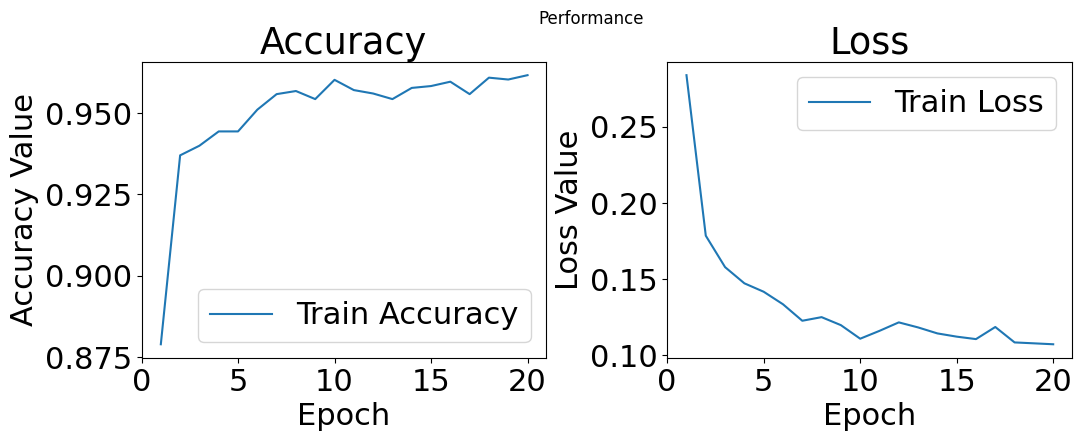

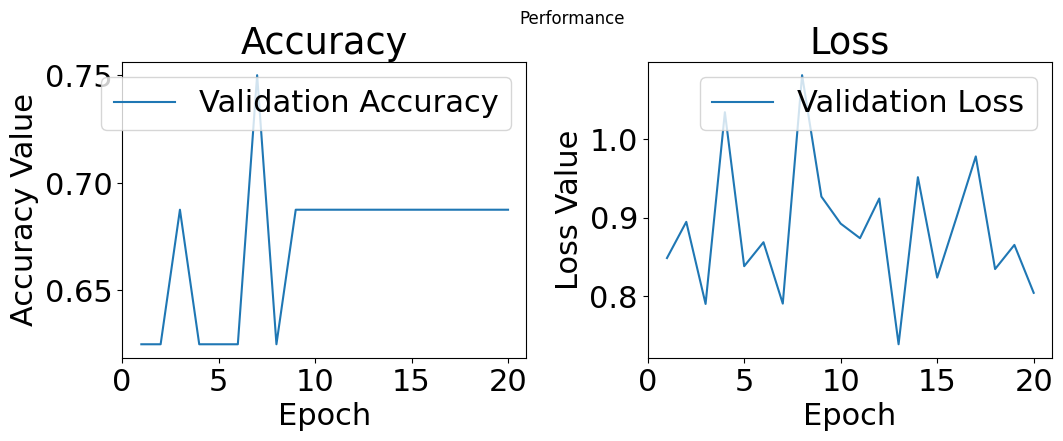

In [112]:
# Training Plot Accuracy and Loss 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,N_EPOCHS+1))
ax1.plot(epoch_list, train_accs, label='Train Accuracy')
ax1.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_losses, label='Train Loss')
ax2.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Validation Plot Accuracy and Loss 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,N_EPOCHS+1))
ax1.plot(epoch_list, val_accs, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, val_losses, label='Validation Loss')
ax2.set_xticks(np.arange(0, N_EPOCHS+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [115]:
model.load_state_dict(torch.load('train_log_wts/ft_all/03-21-23-22/best_model_train_loss_20.pth'), strict=True)

# define criterion
criterion = nn.CrossEntropyLoss()

acc, pred = test(model, test_loader, criterion)

13it [00:01,  6.93it/s]

[TEST]: Loss: 0.45019944570958614, Acc: 0.8541666865348816


In [114]:
model.load_state_dict(torch.load('train_log_wts/ft_all/03-21-23-22/best_model_val_loss_13.pth'), strict=True)

# define criterion
criterion = nn.CrossEntropyLoss()

acc, pred = test(model, test_loader, criterion)

13it [00:01,  6.96it/s]

[TEST]: Loss: 0.41136756281440073, Acc: 0.8621794581413269
